In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline
import pandas as pd
%ls Data

highp_finalresults.csv  lowp_finalresults.csv


In [2]:
# Loads data (Fills NaN values as 0 for simplicity) THERE IS ONLY ONE NaN VALUE 
data=pd.read_csv("./Data/lowp_finalresults.csv",sep = ',',
                 engine = 'python',skipinitialspace = True,na_values = 'NaN ').fillna(0)
# Each row, (for now is a different planet)
# Adds column named n_planet___ it is later going to be summed
data["n_planets"] = 1

# Selects useful planet data only to produce: number of planets, total mass of planets. 
# Identity of system is conserved
planet_data = data[['ident','emepla(i)/emet','n_planets']]

# Selects system data only. 
# System columns corresponding to initial condition
# According to repository README.md, we have to drop: a(i),emegas(i),emepla(i)/emed,rplanet(i)/radtie
system_data = data.drop(['a(i)','emegas(i)','emepla(i)/emet','rplanet(i)/radtie','n_planets'],1)

# System data is repeated as rows represent planets -> so we take the mean
system_data = system_data.groupby(system_data['ident']).mean()

# From planets data it is only necesary the total data (total mass, total number of planets)
planet_data = planet_data.groupby(planet_data['ident']).sum()

# Concatenate two data frames to obtain final formatted data
data = pd.concat([system_data,planet_data], axis=1).reset_index()

# Drops unimportant parameters with null std()
# 0,2,8,9,10,11 are unimportant parameters
# Data for the first point
print(data.keys()[[0,2,8,9,10,11]])
data = data.drop(data.keys()[[0,2,8,9,10,11]],1)

# Creates column corresponding to mass efficiency
data['m_efficiency'] = data['emepla(i)/emet']/data['emed']

# Logarithmic scales for mass-related parameters (1e-5 to avoid log(0)=-infty)
data['emepla(i)/emet'] = np.log(data['emepla(i)/emet']+1e-5)
data['emestar'] = np.log(data['emestar']+1e-5)
data['emed'] = np.log(data['emed']+1e-5)
data['sigmag_0'] = np.log(data['sigmag_0']+1e-5)
data['m_efficiency'] = np.log(data['m_efficiency']+1e-5)


# Important position of parameters
print(' total mass, number of planets, mass efficiency',np.where(data.keys()=='n_planets'),
      np.where(data.keys()=='emepla(i)/emet'),np.where(data.keys()=='m_efficiency'))

# Shows variable data
data.head(15)

Index([u'ident', u't', u'gama', u'apert', u'fpert', u'constmigI'], dtype='object')
(' total mass, number of planets, mass efficiency', (array([9]),), (array([8]),), (array([10]),))


,it,emestar,rc,qest,sigmag_0,emed,emetal,taugas,emepla(i)/emet,n_planets,m_efficiency
0,199992,75.157068,59.882370,1.110726,3.937451,-2.040144,0.077070,9268935.0000,1.902912,12,3.943132
1,198999,74.422324,40.040195,3.201758,2.819352,-3.962790,-0.092791,3525593.5000,1.002589,8,4.965902
2,199995,75.360733,40.647163,1.965345,4.214270,-2.538181,0.514770,9390406.0000,2.374906,12,4.913213
3,199780,74.967751,29.539343,9.568532,2.785820,-4.604171,0.328146,1644710.6250,1.855848,23,6.461017
4,198727,74.742551,61.195038,2.230675,2.764218,-3.169848,-0.220031,9468353.0000,1.082869,10,4.252951
5,199637,75.485455,38.977428,5.082291,3.455076,-3.381101,-0.150160,1014449.0625,1.440741,16,4.822133
6,199074,74.912779,47.343380,5.121542,2.535559,-3.911523,0.021273,1790533.1250,0.817900,15,4.729919
7,199677,74.853960,42.739063,3.225643,3.111750,-3.540115,-0.092571,2721394.7500,1.318801,15,4.859258
8,198375,75.488793,58.158928,4.369815,2.912512,-3.123338,-0.282408,6017040.5000,1.342241,9,4.465804
9,199989,75.323966,30.851170,1.224490,5.096811,-2.207184,-0.065073,1576467.7500,2.497579,9,4.704853


In [3]:
# Efficiency function
def efficiency(y_predicted, y_test):
    return np.exp(-0.5*(sum((y_predicted-y_test)**2)/(len(y_test)*(y_test.std()**2))))

# This function gets efficiencies for varying parameters> weights and n_neighbors
def getEffs(Xdata,Ydata, nmax):

    # Splits data into trainig and test set.
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.25,
                                                    random_state=int(100*np.random.random()))
    # Empty lists of efficiencies
    uniform = []
    distance = []
                                                        
    # number of neighbors vary from [1 to nmax)
    for i in range(1,nmax):
                                                        
        # Initializes the regressor with uniform weight
        neigh = KNeighborsRegressor(n_neighbors=i, weights = 'uniform' )
        # Algorithm training
        neigh.fit(X_train, y_train)
        # Prediction from test                                                
        y_predicted = neigh.predict(X_test)
        # Efficiency
        epsilon = efficiency(y_predicted,y_test)
        # Append
        uniform.append(epsilon)
        
        # Process is repeated for distance-weighted algorithm
        neigh = KNeighborsRegressor(n_neighbors=i, weights = 'distance' )
        neigh.fit(X_train, y_train)
        y_predicted = neigh.predict(X_test)
        epsilon = efficiency(y_predicted,y_test)
        distance.append(epsilon)
        
    uniform = np.array(uniform)
    distance = np.array(distance)
    return uniform,distance

# This method trains the algorithm and returns the trained object ready for predictions.
# Parameters weight and number_neighs to be given
def getNeigh( X_train, y_train,weight='uniform',number_neighs=5):
    # Initializes the regressor with uniform weight
    neigh = KNeighborsRegressor(n_neighbors=number_neighs, weights = weight )
    # Algorithm training
    neigh.fit(X_train, y_train)
    
    return neigh

# Plots each column of X vs y
# if bool = true, it also plots ypred
# indie is the index of the component represented on Y axis
def plott(X,y,data, indie, ypred=None ,boolean = False):
    import matplotlib.gridspec as gridspec
    fig, axes = plt.subplots( nrows=4, ncols=4, figsize=(15,20) )
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    #plt.title( 'Sample of relations in training data' )
    gs = gridspec.GridSpec(4,2)
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[2, 0])
    ax5 = plt.subplot(gs[2, 1])
    ax6 = plt.subplot(gs[3, 0])
    ax7 = plt.subplot(gs[3, 1])
    axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
    for i in range(len(np.array(X).T)):
        #print(i)
        ax = axes[i]
        ax.plot(np.array(X).T[i],y, marker = 'o', linewidth = 0, alpha = 0.3 , c = 'b', label = 'Real')
        if( boolean ):
            ax.plot(np.array(X).T[i],ypred, marker = 'o', linewidth = 0, alpha = 0.3, c = 'r',label = 'Predicted')
        ax.set_xlabel(data.keys()[i], fontsize = 30)
        ax.set_ylabel(data.keys()[indie], fontsize = 30)
        ax.legend()

# Amount of planets 

In [4]:
# Non initial condition parameters are dropped (total mass, mass efficiency)
#data[data.keys()[9]] = np.log(data[data.keys()[9]]+1e-5)
print(data.keys()[8],data.keys()[9])
Xdata =  data[data.keys()[:8]]
Ydata =  data[data.keys()[9]]
# Gets the efficiencies
nmax = 20
uniform,distance = getEffs(Xdata,Ydata,nmax)

('emepla(i)/emet', 'n_planets')


('uniform', 7)


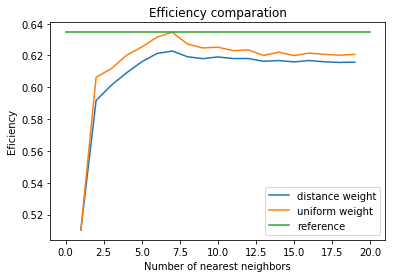

In [5]:
# Maximum efficiency
maxi  = max([max(distance),max(uniform)])
# Chooses beteween uniform or distance weight
weight = ['distance','uniform'][np.argmax([max(distance),max(uniform)])]
# Most efficient number of neighbors
N_neigh = np.argmax([distance,uniform][np.argmax([max(distance),max(uniform)])])+1
print(weight,N_neigh)

# Plots efficiency comparison
plt.plot(range(1,nmax),distance, label = 'distance weight')
plt.plot(range(1,nmax),uniform, label = 'uniform weight')
plt.plot([0,nmax],[maxi,maxi], label = 'reference')
plt.xlabel('Number of nearest neighbors')
plt.ylabel('Eficiency')
plt.title('Efficiency comparation')
plt.legend()

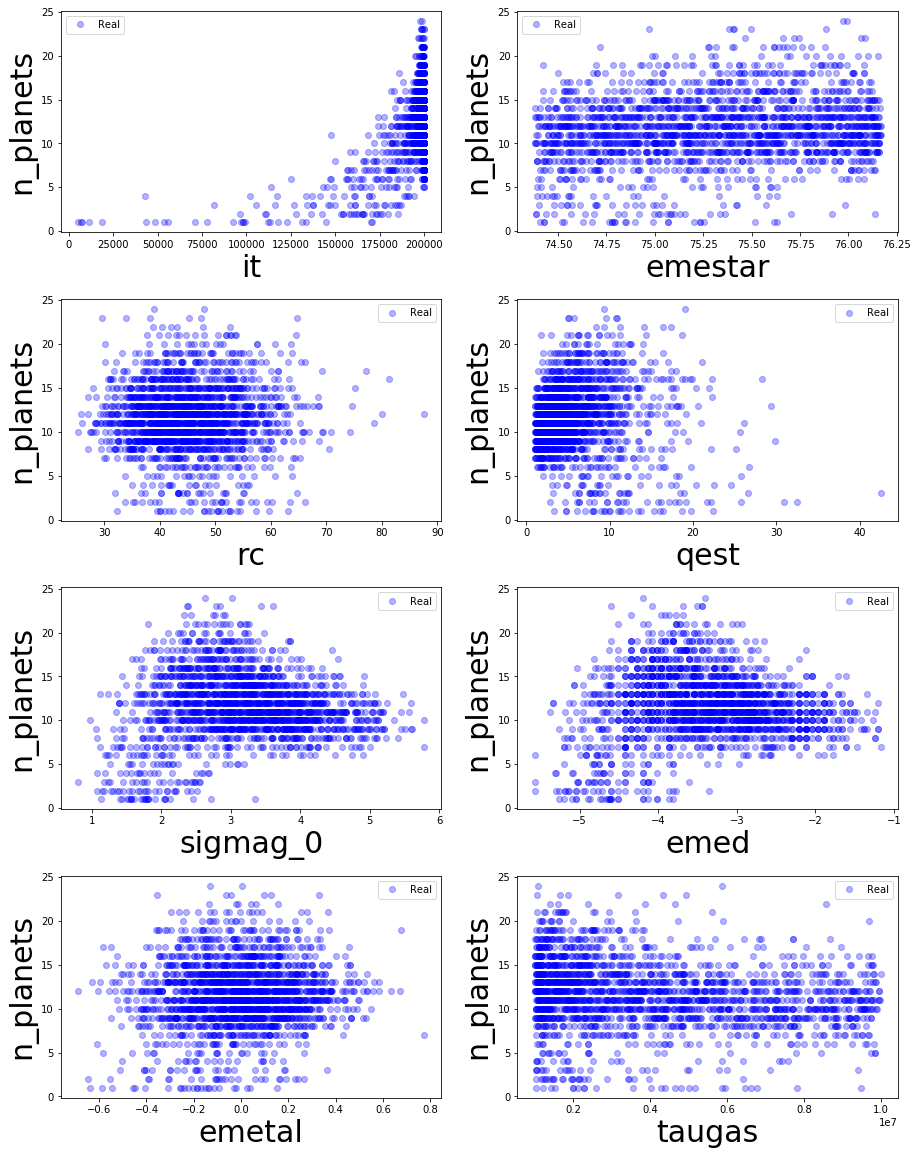

In [6]:
# Splits data into trainig and test set.
X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.25,
                                                    random_state=int(100*np.random.random()))

# Plots X_train, y_train
plott(X_train,y_train,data,9)

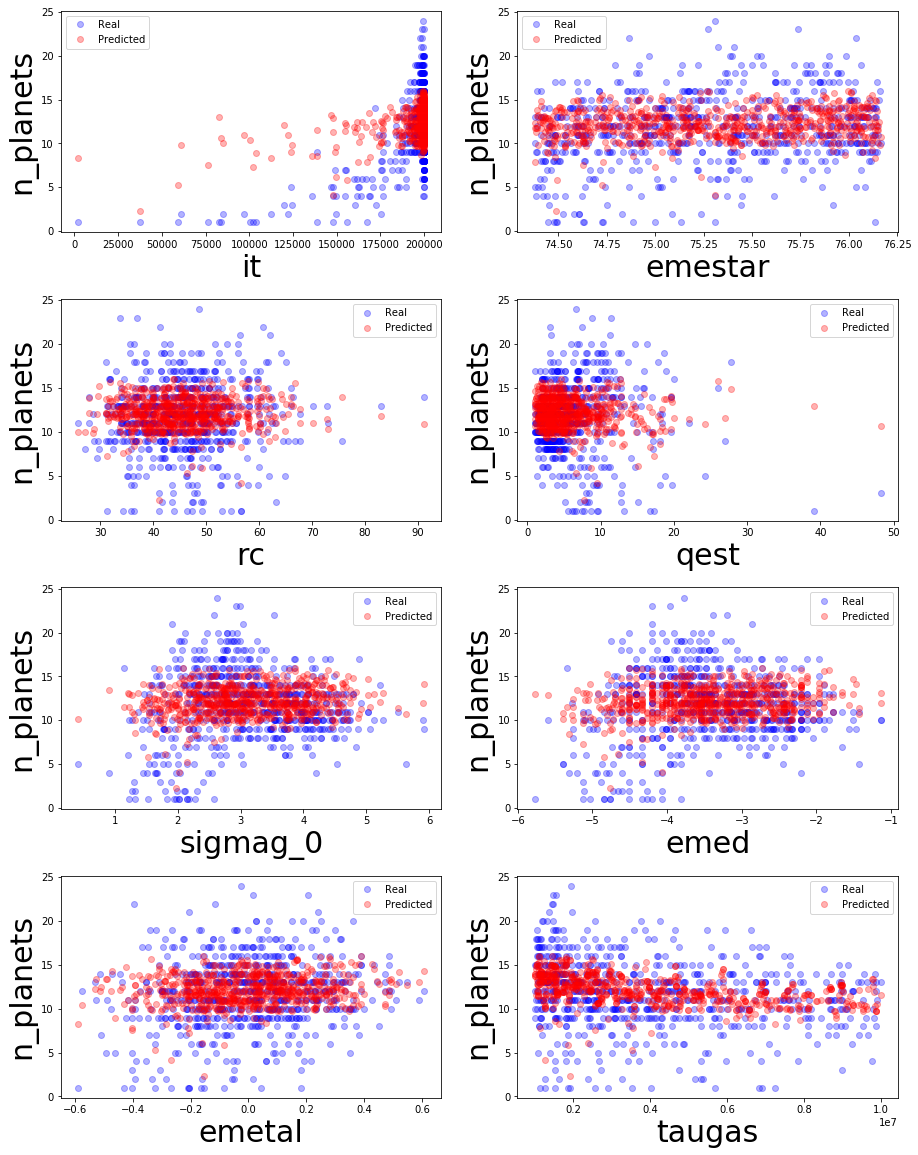

In [7]:
# Gets trained algorithm
neigh = getNeigh(X_train,y_train,number_neighs=N_neigh, weight=weight)
# Gets prediction
y_predicted = neigh.predict(X_test)

# Plots: 
# Plots X_test y_test, y_pred
plott(X_test,y_test,data,indie = 9, ypred=y_predicted, boolean=True )

# Total mass prediction

In [8]:
# Non initial condition parameters are dropped (total mass, mass efficiency)
print(data.keys()[8],data.keys()[8])
Xdata =  data[data.keys()[:8]]
Ydata =  data[data.keys()[8]]
# Gets the efficiencies
nmax = 20
uniform,distance = getEffs(Xdata,Ydata,nmax)

('emepla(i)/emet', 'emepla(i)/emet')


('uniform', 9)


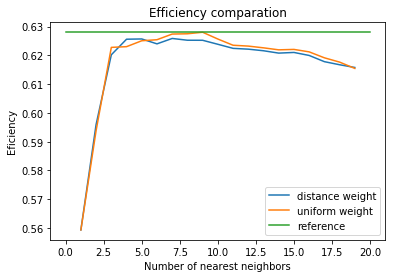

In [9]:
# Maximum efficiencyx_tra
maxi  = max([max(distance),max(uniform)])
# Chooses beteween uniform or distance weight
weight = ['distance','uniform'][np.argmax([max(distance),max(uniform)])]
# Most efficient number of neighbors
N_neigh = np.argmax([distance,uniform][np.argmax([max(distance),max(uniform)])])+1
print(weight,N_neigh)

# Plots efficiency comparison
plt.plot(range(1,nmax),distance, label = 'distance weight')
plt.plot(range(1,nmax),uniform, label = 'uniform weight')
plt.plot([0,nmax],[maxi,maxi], label = 'reference')
plt.xlabel('Number of nearest neighbors')
plt.ylabel('Eficiency')
plt.title('Efficiency comparation')
plt.legend()

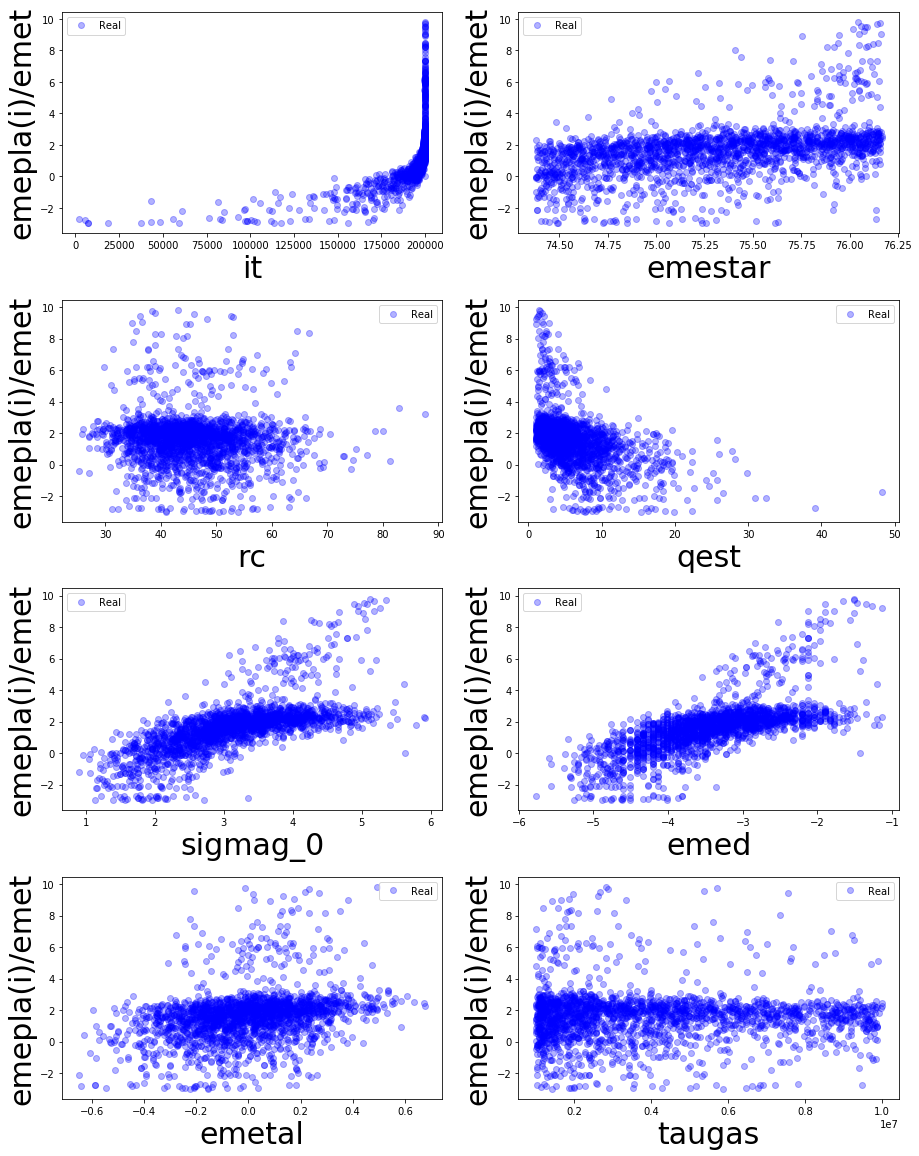

In [10]:
# Splits data into trainig and test set.
X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.25,
                                                    random_state=int(100*np.random.random()))

# Plots X_train, y_train
plott(X_train,y_train,data,8)

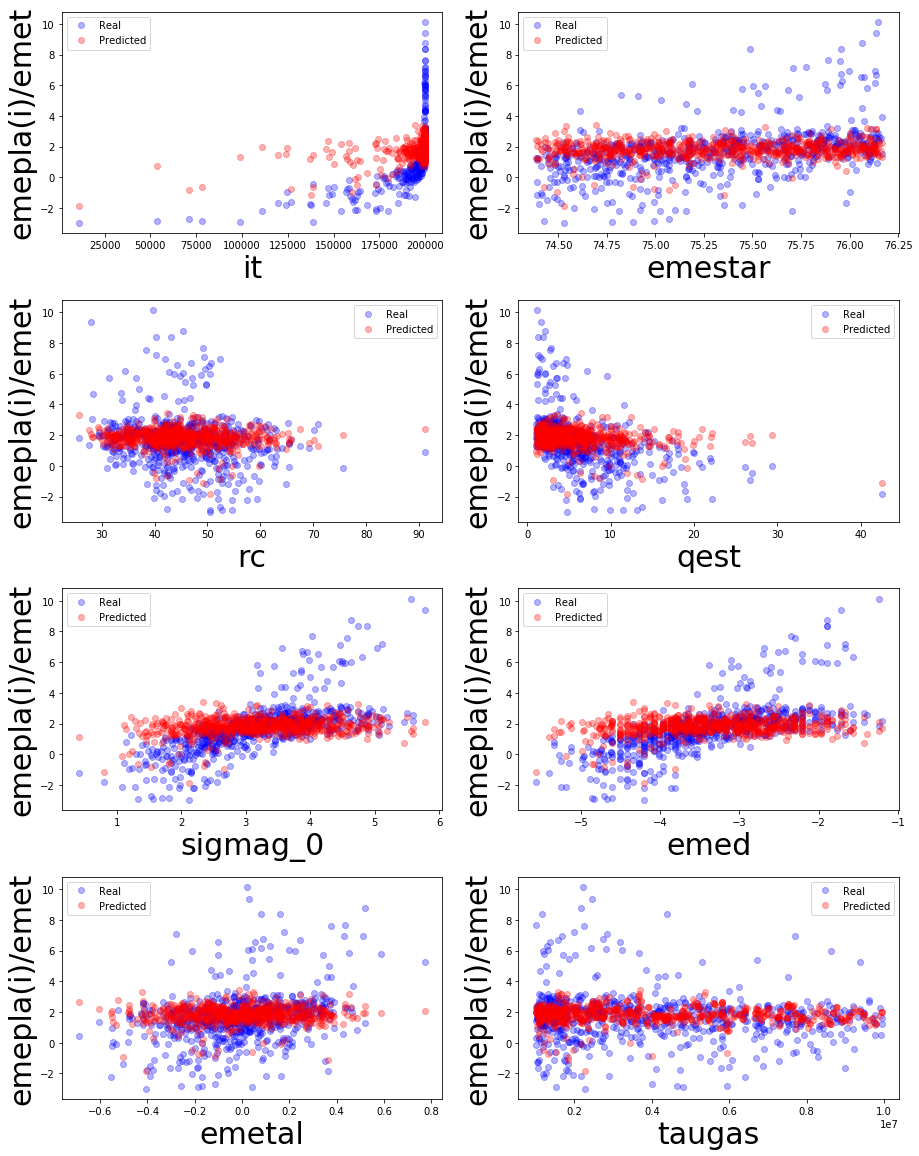

In [11]:
# Gets trained algorithm
neigh = getNeigh(X_train,y_train,number_neighs=N_neigh, weight=weight)
# Gets prediction
y_predicted = neigh.predict(X_test)

# Plots: 
# Plots X_test y_test, y_pred
plott(X_test,y_test,data,indie = 8, ypred=y_predicted, boolean=True )

# Mass efficiency prediction

In [12]:
# Non initial condition parameters are dropped (total mass, mass efficiency)
# Disk information is dropped. If this is included, this prediction is the same as the prediction of the total mass
data2 = data.drop('emed',1)
#data2['m_efficiency'] = np.log(data2['m_efficiency'] +1e-6)
print(data2.keys()[7],data2.keys()[9])
Xdata =  data2[data2.keys()[:7]]
Ydata =  data2[data2.keys()[9]]
# Gets the efficiencies
nmax = 20
uniform,distance = getEffs(Xdata,Ydata,nmax)

('emepla(i)/emet', 'm_efficiency')


('uniform', 12)


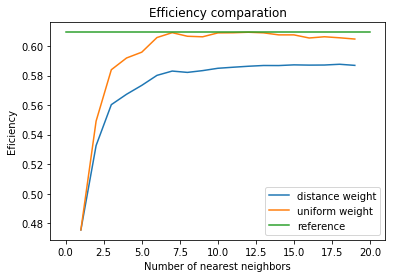

In [13]:
# Maximum efficiency
maxi  = max([max(distance),max(uniform)])
# Chooses beteween uniform or distance weight
weight = ['distance','uniform'][np.argmax([max(distance),max(uniform)])]
# Most efficient number of neighbors
N_neigh = np.argmax([distance,uniform][np.argmax([max(distance),max(uniform)])])+1
print(weight,N_neigh)

maxi  = max([max(distance),max(uniform)])
plt.plot(range(1,nmax),distance, label = 'distance weight')
plt.plot(range(1,nmax),uniform, label = 'uniform weight')
plt.plot([0,nmax],[maxi,maxi], label = 'reference')
plt.xlabel('Number of nearest neighbors')
plt.ylabel('Eficiency')
plt.title('Efficiency comparation')
plt.legend()

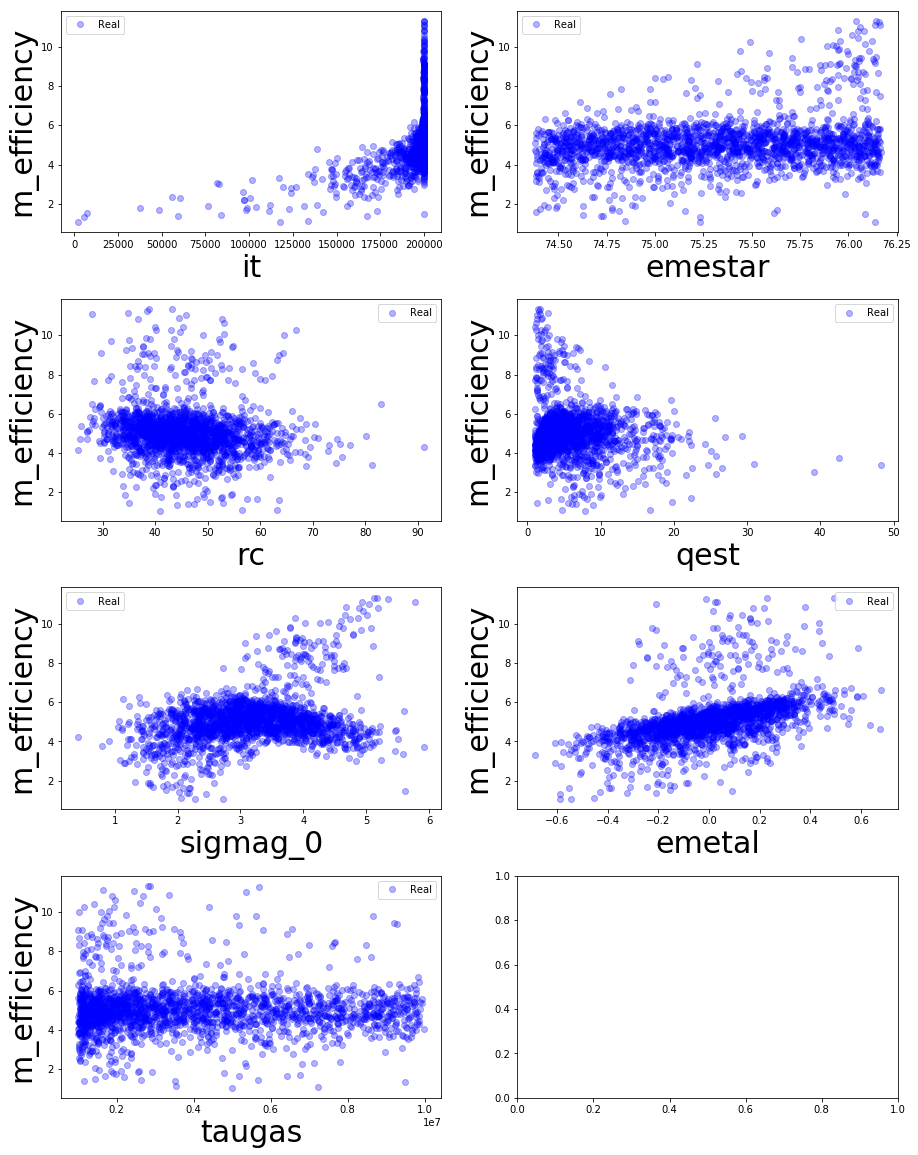

In [14]:
# Splits data into trainig and test set.
X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.25,
                                                    random_state=int(100*np.random.random()))

# Plots X_train, y_train
plott(X_train,y_train,data2,9)

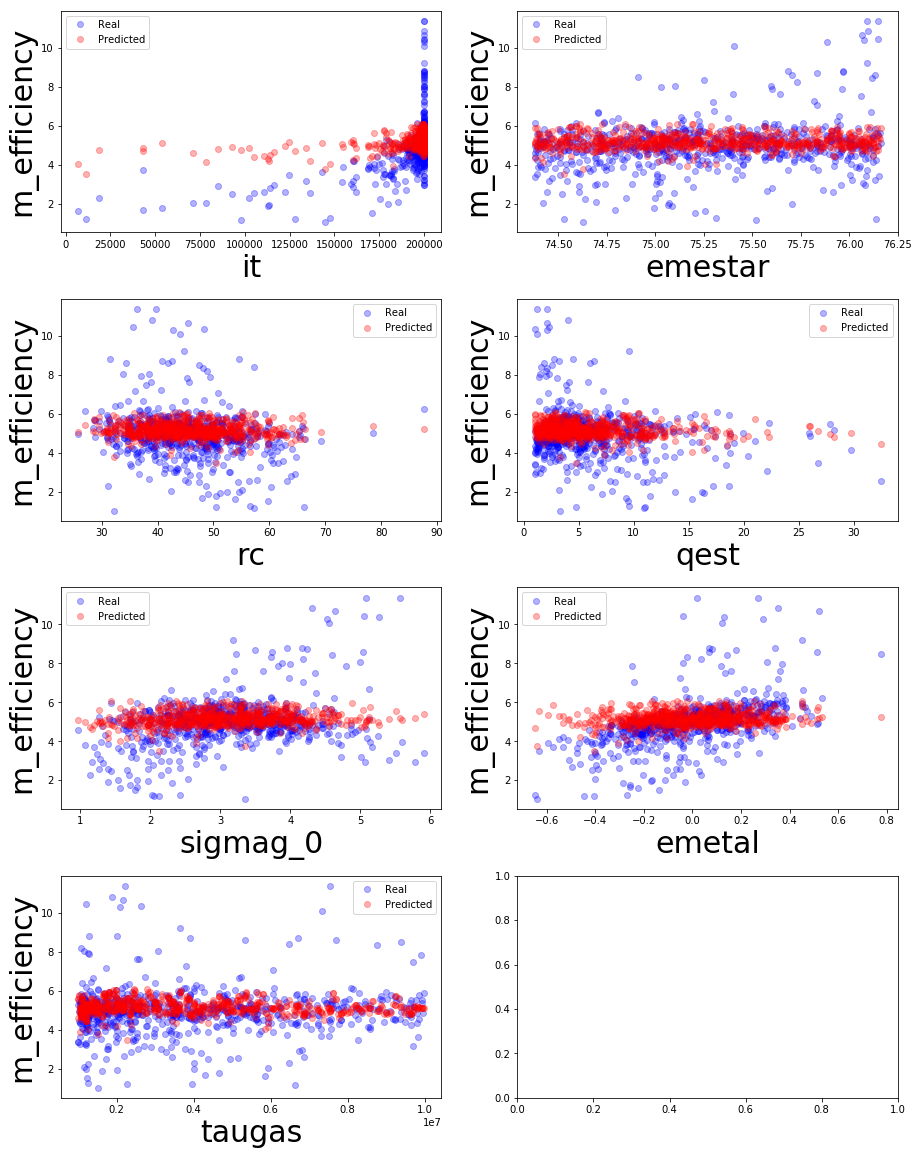

In [15]:
# Gets trained algorithm
neigh = getNeigh(X_train,y_train,number_neighs=N_neigh, weight=weight)
# Gets prediction
y_predicted = neigh.predict(X_test)

# Plots: 
# Plots X_test y_test, y_pred
plott(X_test,y_test,data2,indie = 9, ypred=y_predicted, boolean=True )

# Findig the most important parameters

For finding the most relevant parameters we decide to use decison tree. This method allows us to make superviced machine learning with non-linear data. The higher the value asociated with the parameter it has a biger importance.

For this part we do not split data, since there is no need to test the result but to se what variables make a biger difference in clasifiying the data.


## Finding relevant parameters for the number of planets

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
# Non initial condition parameters are dropped (total mass, mass efficiency)
#data[data.keys()[9]] = np.log(data[data.keys()[9]]+1e-5)
print(data.keys()[8],data.keys()[9])
Xdata =  data[data.keys()[:8]]
Ydata =  data[data.keys()[9]]

('emepla(i)/emet', 'n_planets')


In [18]:
rf = RandomForestRegressor()
rf.fit(Xdata,Ydata)
arr = np.argsort(rf.feature_importances_)
for name, value in zip(data.keys()[arr[::-1]], rf.feature_importances_[arr[::-1]]):
    print(name, value)

('it', 0.4707765657740598)
('taugas', 0.14660760498347111)
('qest', 0.12860606320812115)
('sigmag_0', 0.070622710416102283)
('emestar', 0.059715345404353103)
('rc', 0.046151723358540474)
('emetal', 0.045294476038174353)
('emed', 0.032225510817177665)


## Finding the most important parameters for total mass prediction

In [19]:
# Non initial condition parameters are dropped (total mass, mass efficiency)
print(data.keys()[8],data.keys()[8])
Xdata =  data[data.keys()[:8]]
Ydata =  data[data.keys()[8]]

('emepla(i)/emet', 'emepla(i)/emet')


In [20]:
rf = RandomForestRegressor()
rf.fit(Xdata,Ydata)
arr = np.argsort(rf.feature_importances_)
for name, value in zip(data.keys()[arr[::-1]], rf.feature_importances_[arr[::-1]]):
    print(name, value)

('it', 0.58317596366740143)
('emestar', 0.085571496881358552)
('emed', 0.084724111881901626)
('taugas', 0.075770903155149449)
('emetal', 0.06260609121518311)
('sigmag_0', 0.050295092248763697)
('rc', 0.029561071361281575)
('qest', 0.02829526958896041)


## Finding the most important parameters for mass efficency prediction

In [21]:
# Non initial condition parameters are dropped (total mass, mass efficiency)
# Disk information is dropped. If this is included, this prediction is the same as the prediction of the total mass
data2 = data.drop('emed',1)
#data2['m_efficiency'] = np.log(data2['m_efficiency'] +1e-6)
print(data2.keys()[7],data2.keys()[9])
Xdata =  data2[data2.keys()[:7]]
Ydata =  data2[data2.keys()[9]]

('emepla(i)/emet', 'm_efficiency')


In [22]:
rf = RandomForestRegressor()
rf.fit(Xdata,Ydata)
arr = np.argsort(rf.feature_importances_)
for name, value in zip(data.keys()[arr[::-1]], rf.feature_importances_[arr[::-1]]):
    print(name, value)

('it', 0.34496119503993156)
('emed', 0.20479705478525964)
('sigmag_0', 0.1121580027396929)
('emetal', 0.11167584409498113)
('emestar', 0.091295249254248173)
('qest', 0.070744392255894836)
('rc', 0.064368261829991724)
